# Flow directions from elevation data

Flow directions are typically derived from a conditioned (high resolution) Digital Elevation Models (DEMs) using the so-called 'steepest gradient' method. This method selects the lowest direct neighbor of each cell as its donstream flow direction. HydroMT implements the algorithm proposed by  [Wang & Liu (2006)](https://doi.org/10.1080/13658810500433453) which is used in this example.

In [1]:
import rasterio
import numpy as np
import pyflwdir
from utils import (
    quickplot,
    colors,
    cm,
    plt,
)  # data specific quick plot convenience method

# read elevation data of the rhine basin using rasterio
with rasterio.open("rhine_elv0.tif", "r") as src:
    elevtn = src.read(1)
    nodata = src.nodata
    transform = src.transform
    crs = src.crs
    extent = np.array(src.bounds)[[0, 2, 1, 3]]
    latlon = src.crs.is_geographic
    prof = src.profile

Text(0, 0.5, 'elevation [m+EGM96]')

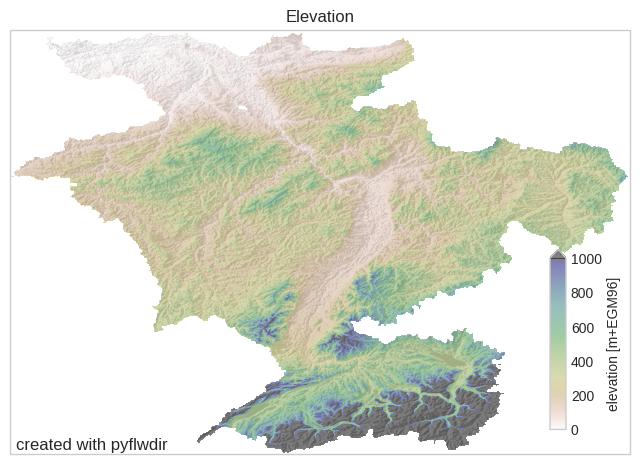

In [2]:
ax = quickplot(title="Elevation")
im = ax.imshow(
    np.ma.masked_equal(elevtn, -9999),
    extent=extent,
    cmap="gist_earth_r",
    alpha=0.5,
    vmin=0,
    vmax=1000,
)
fig = plt.gcf()
cax = fig.add_axes([0.8, 0.37, 0.02, 0.12])
fig.colorbar(im, cax=cax, orientation="vertical", extend="max")
cax.set_ylabel("elevation [m+EGM96]")
# plt.savefig('elevation.png', dpi=225, bbox_axis='tight')

## Derive flow direction

 
 Here we use the [from_dem()](https://deltares.github.io/PyFlwDir/latest/_generated/pyflwdir.pyflwdir.from_dem.html) method to retrieve a [FlwDirRaster](https://deltares.github.io/PyFlwDir/latest/_generated/pyflwdir.FlwdirRaster.html) object based on the flow directions as derived with steepest gradient algorithm. This method wraps the [dem.fill_depressions()](https://deltares.github.io/PyFlwDir/latest/_generated/pyflwdir.dem.fill_depressions.html) method which returns a depression-filled elevation raster and a local flow directions array following the arcgis D8 convention.
 
 The algorithm assumes that outlets occur at the edge of valid elevation cells. Elevation depressions are filled based on its lowest pour point elevation. If the depression depth relative to the pour point is larger than the maximum pour point depth `max_depth` a pit is set at the depression local minimum elevation (not used in this example). Optionally, all flow direction can be forced towards a single outlet at the lowest edge cell by setting the `outlets='min'` keyword. The `trasform` and `latlon` arguments define the geospatial location of the data.

<div class="alert alert-info">

NOTE: that for most methods a first call might be a bit slow as the numba code is compiled just in time, a second call of the same methods (also with different arguments) will be much faster!
    
</div>

In [3]:
# returns FlwDirRaster object
flw = pyflwdir.from_dem(
    data=elevtn,
    nodata=src.nodata,
    transform=transform,
    latlon=latlon,
    outlets="min",
)

We visualize the derived flow directions by plotting all streams with a minimum strahler order of 4, see [streams()](https://deltares.github.io/PyFlwDir/latest/_generated/pyflwdir.FlwdirRaster.streams.html) method.

In [4]:
import geopandas as gpd

feats = flw.streams(min_sto=4)
gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)

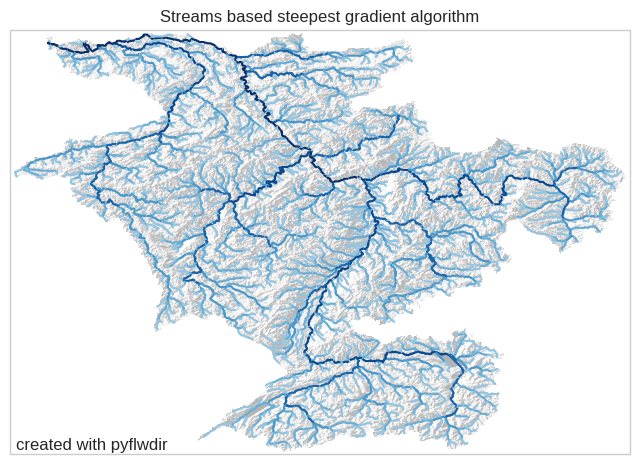

In [5]:
# create nice colormap of Blues with less white
cmap_streams = colors.ListedColormap(cm.Blues(np.linspace(0.4, 1, 7)))
gdf_plot_kwds = dict(column="strord", cmap=cmap_streams)
# plot streams with hillshade from elevation data (see utils.py)
ax = quickplot(
    gdfs=[(gdf, gdf_plot_kwds)],
    title="Streams based steepest gradient algorithm",
    filename="flw_streams_steepest_gradient",
)

## Save flow direction raster

With the [to_array()](https://deltares.github.io/PyFlwDir/latest/_generated/pyflwdir.FlwdirRaster.to_array.html) method we can return a flow direction numpy array from the `FlwDirRaster` object in any supported convention. This can be saved to a geospatial raster file using rasterio as shown below.

In [6]:
d8_data = flw.to_array(ftype="d8")
d8_data

array([[247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247],
       ...,
       [247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247]], dtype=uint8)

In [7]:
# update data type and nodata value properties which are different compared to the input elevation grid and write to geotif
prof.update(dtype=d8_data.dtype, nodata=247)
with rasterio.open("flwdir.tif", "w", **prof) as src:
    src.write(d8_data, 1)